# RecordManager

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

from torchhk import *

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## 1. MNIST Data

In [3]:
train_data = dsets.MNIST(root='./data/',
                         train=True,
                         transform=transforms.ToTensor(),
                         download=True)

test_data = dsets.MNIST(root='./data/',
                        train=False,
                        transform=transforms.ToTensor(),
                        download=True)

In [4]:
batch_size = 100

train_loader = DataLoader(dataset=train_data,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(dataset=test_data,
                         batch_size=batch_size,
                         shuffle=True)

## 2. Define Model

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv_layer = nn.Sequential(
            nn.Conv2d(1,16,5),
            nn.ReLU(),
            nn.Conv2d(16,32,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,64,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(64*3*3,100),
            nn.ReLU(),
            nn.Linear(100,10)
        )       
        
    def forward(self,x):
        out = self.conv_layer(x)
        out = out.view(-1,64*3*3)
        out = self.fc_layer(out)

        return out

In [6]:
model = CNN().cuda()

In [7]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 3. Train Model

In [8]:
num_epochs = 3

In [9]:
rm = RecordManager(['Epoch', 'Iter', 'Loss', 'Accuracy'])
rm

RecordManager(keys=[Epoch, Iter, Loss, Accuracy])

In [10]:
def test(test_loader) :

    model.eval()

    correct = 0
    total = 0

    for images, labels in test_loader:

        images = images.cuda()
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum()

    return (100 * float(correct) / total)

In [11]:
for epoch in range(num_epochs):
    
    total_batch = len(train_data) // batch_size

    for i, (batch_images, batch_labels) in enumerate(train_loader):

        X = batch_images.cuda()
        Y = batch_labels.cuda()

        pre = model(X)
        cost = loss(pre, Y)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        rm.progress()
        
        if (i+1) % 300 == 0:
            acurracy = test(test_loader)
            model.train()

            rm.add([epoch+1, i+1, cost.item(), acurracy])

rm.summary()

-----------------------------------                
Epoch   Iter   Loss     Accuracy   
1       300    0.0992   97.0400    
-----------------------------------
1       600    0.1083   98.1200                    
-----------------------------------
2       300    0.1116   98.5500                    
-----------------------------------
2       600    0.0348   98.8500                    
-----------------------------------
3       300    0.0141   98.7900                    
-----------------------------------
3       600    0.0844   99.0800                    
-----------------------------------
Total Epoch: 3
Time Elapsed: 0:00:34.397991
Min(epoch)/Max(epoch): 
-Loss: 0.0141(3)/0.1116(2)
-Accuracy: 97.0400(1)/99.0800(3)
-----------------------------------


## 4. Plot & Save

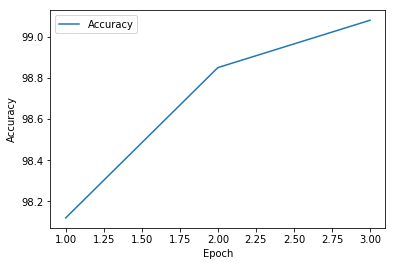

In [12]:
rm.plot('Epoch', 'Accuracy')

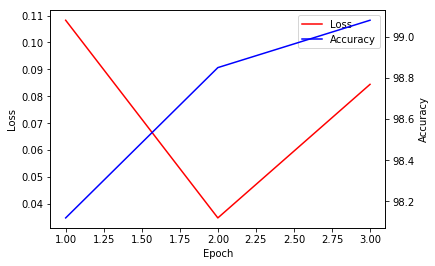

In [13]:
rm.plot('Epoch', ['Loss', 'Accuracy'], loc='upper right')

In [14]:
rm.to_csv("pd.csv")

...Saved as csv to pd.csv !


In [15]:
rm.save("pd.pkl")

...Saved as pickle to pd.pkl !
